In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")

In [2]:
# Skip date
df1 = pd.read_csv(r'C:\Users\SIMRAN\Desktop\final_data_netflix.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::1, :])

Dataset 1 shape: (319936, 2)
-Dataset examples-
        Cust_Id  Rating
0            1:     NaN
1       1488844     3.0
2        822109     5.0
3        885013     4.0
4         30878     4.0
5        823519     3.0
6        893988     3.0
7        124105     4.0
8       1248029     3.0
9       1842128     4.0
10      2238063     3.0
11      1503895     4.0
12      2207774     5.0
13      2590061     3.0
14         2442     3.0
15       543865     4.0
16      1209119     4.0
17       804919     4.0
18      1086807     3.0
19      1711859     4.0
20       372233     5.0
21      1080361     3.0
22      1245640     3.0
23       558634     4.0
24      2165002     4.0
25      1181550     3.0
26      1227322     4.0
27       427928     4.0
28       814701     5.0
29       808731     4.0
...         ...     ...
319906  1258602     3.0
319907   269808     3.0
319908    19106     4.0
319909  2144806     3.0
319910   623400     5.0
319911   533598     5.0
319912  1426869     4.0
319913   911333 

In [3]:
# # load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::1, :])

Full dataset shape: (319936, 2)
-Dataset examples-
        Cust_Id  Rating
0            1:     NaN
1       1488844     3.0
2        822109     5.0
3        885013     4.0
4         30878     4.0
5        823519     3.0
6        893988     3.0
7        124105     4.0
8       1248029     3.0
9       1842128     4.0
10      2238063     3.0
11      1503895     4.0
12      2207774     5.0
13      2590061     3.0
14         2442     3.0
15       543865     4.0
16      1209119     4.0
17       804919     4.0
18      1086807     3.0
19      1711859     4.0
20       372233     5.0
21      1080361     3.0
22      1245640     3.0
23       558634     4.0
24      2165002     4.0
25      1181550     3.0
26      1227322     4.0
27       427928     4.0
28       814701     5.0
29       808731     4.0
...         ...     ...
319906  1258602     3.0
319907   269808     3.0
319908    19106     4.0
319909  2144806     3.0
319910   623400     5.0
319911   533598     5.0
319912  1426869     4.0
319913   9113

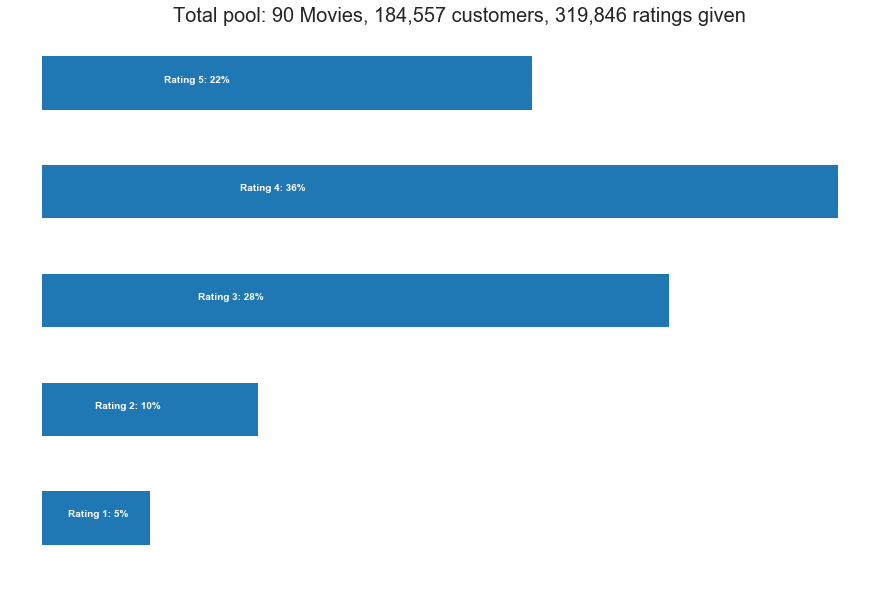

In [4]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [5]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [ 1.  1.  1. ... 90. 90. 90.]
Length: 319846


In [6]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::1, :])

-Dataset examples-
        Cust_Id  Rating  Movie_Id
1       1488844     3.0         1
2        822109     5.0         1
3        885013     4.0         1
4         30878     4.0         1
5        823519     3.0         1
6        893988     3.0         1
7        124105     4.0         1
8       1248029     3.0         1
9       1842128     4.0         1
10      2238063     3.0         1
11      1503895     4.0         1
12      2207774     5.0         1
13      2590061     3.0         1
14         2442     3.0         1
15       543865     4.0         1
16      1209119     4.0         1
17       804919     4.0         1
18      1086807     3.0         1
19      1711859     4.0         1
20       372233     5.0         1
21      1080361     3.0         1
22      1245640     3.0         1
23       558634     4.0         1
24      2165002     4.0         1
25      1181550     3.0         1
26      1227322     4.0         1
27       427928     4.0         1
28       814701     5.0      

C:\Users\SIMRAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\SIMRAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [7]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.0),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.0),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 90.0
Customer minimum times of review: 1.0


In [8]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::1, :])

Original Shape: (319846, 3)
After Trim Shape: (319846, 3)
-Data Examples-
        Cust_Id  Rating  Movie_Id
1       1488844     3.0         1
2        822109     5.0         1
3        885013     4.0         1
4         30878     4.0         1
5        823519     3.0         1
6        893988     3.0         1
7        124105     4.0         1
8       1248029     3.0         1
9       1842128     4.0         1
10      2238063     3.0         1
11      1503895     4.0         1
12      2207774     5.0         1
13      2590061     3.0         1
14         2442     3.0         1
15       543865     4.0         1
16      1209119     4.0         1
17       804919     4.0         1
18      1086807     3.0         1
19      1711859     4.0         1
20       372233     5.0         1
21      1080361     3.0         1
22      1245640     3.0         1
23       558634     4.0         1
24      2165002     4.0         1
25      1181550     3.0         1
26      1227322     4.0         1
27      

In [9]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(184557, 90)


In [25]:
df_title = pd.read_csv(r'C:\Users\SIMRAN\Desktop\movie_titles old.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(90))

            Year                                               Name
Movie_Id                                                           
1         2003.0                                    Dinosaur Planet
2         2004.0                         Isle of Man TT 2004 Review
3         1997.0                                          Character
4         1994.0                       Paula Abdul's Get Up & Dance
5         2004.0                           The Rise and Fall of ECW
6         1997.0                                               Sick
7         1992.0                                              8 Man
8         2004.0                         What the #$*! Do We Know!?
9         1991.0                           Class of Nuke 'Em High 2
10        2001.0                                            Fighter
11        1999.0                     Full Frame: Documentary Shorts
12        1947.0                               My Favorite Brunette
13        2003.0  Lord of the Rings: The Return 

In [26]:
print(df_p)

Movie_Id  1   2   3   4   5   6   7    8   9   10 ...   81  82  83  84   85  \
Cust_Id                                           ...                         
6        NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN ...  NaN NaN NaN NaN  NaN   
7        NaN NaN NaN NaN NaN NaN NaN  5.0 NaN NaN ...  NaN NaN NaN NaN  NaN   
42       NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN ...  NaN NaN NaN NaN  NaN   
59       NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN ...  NaN NaN NaN NaN  NaN   
79       NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN ...  NaN NaN NaN NaN  NaN   
94       NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN ...  NaN NaN NaN NaN  NaN   
116      NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN ...  NaN NaN NaN NaN  NaN   
134      NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN ...  NaN NaN NaN NaN  NaN   
168      NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN ...  NaN NaN NaN NaN  NaN   
183      NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN ...  NaN NaN NaN NaN  NaN   
188      NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN ..

In [27]:
def pcorr(movie_title):
    print("For movie ({})".format(movie_title))
    print("-Movie's Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    corr_target.to_csv(r'C:\Users\SIMRAN\Desktop\mock1_NF_Op.csv', sep='\t', encoding='utf-8')
    print(corr_target)

In [28]:
pcorr("Character")

For movie (Character)
-Movie's Pearsons'R correlation - 
          PearsonR                                               Name   count  \
Movie_Id                                                                        
3         1.000000                                          Character    2012   
20        0.942121                                    Seeta Aur Geeta     116   
2         0.926367                         Isle of Man TT 2004 Review     145   
14        0.887520                                 Nature: Antarctica     118   
34        0.883452  Ashtanga Yoga: Beginner's Practice with Nicki ...     108   
54        0.814716                                  We're Not Married     159   
50        0.789746                               A Yank in the R.A.F.     328   
1         0.779436                                    Dinosaur Planet     547   
12        0.775580                               My Favorite Brunette     546   
4         0.771744                       Paula Abdul

In [29]:
predn= pd.read_excel(r"C:\Users\SIMRAN\Desktop\pred_netflix.xlsx")
predn.head(10)

,Movie_Id,PearsonR,Name,User(1025579)
0,81,0.004440,Clerks,4
1,84,0.492815,Elizabeth,5
2,88,0.194507,In the Mood for Love,5
3,89,0.309091,Trainspotting,4
4,90,0.131918,The English Patient,3


In [30]:
(predn["PearsonR"] * predn["User(1025579)"]).sum() / abs(predn["PearsonR"]).sum()


4.490306382437246

In [31]:
predc= pd.read_excel(r"C:\Users\SIMRAN\Desktop\pred_combined.xlsx")
predc.head(10)

,Movie_Id,PearsonR,Name,User(1025579)
0,82,0.329547,Clerks,4
1,86,0.246408,Elizabeth,5
2,90,0.597254,In the Mood for Love,5
3,91,0.627001,Trainspotting,4
4,92,0.301661,The English Patient,3


In [32]:
(predc["PearsonR"] * predc["User(1025579)"]).sum() / abs(predc["PearsonR"]).sum()


4.257865709111592

In [33]:
import numpy as np
d = [4]
p = [4.490306382437246]

print("d is: " + str(["%.8f" % elem for elem in d]))
print("p is: " + str(["%.8f" % elem for elem in p]))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(np.array(d), np.array(p))
print("rms error is: " + str(rmse_val))

d is: ['4.00000000']
p is: ['4.49030638']
rms error is: 0.4903063824372458


In [34]:
import numpy as np
d = [4]
p = [4.257865709111592]

print("d is: " + str(["%.8f" % elem for elem in d]))
print("p is: " + str(["%.8f" % elem for elem in p]))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(np.array(d), np.array(p))
print("rms error is: " + str(rmse_val))

d is: ['4.00000000']
p is: ['4.25786571']
rms error is: 0.25786570911159234
